In [ ]:
#! pip install datasets transformers rouge-score nltk torch numpy matplotlib      # << Uncomment to install packages
import transformers
print(transformers.__version__)     # Should be >= 4.11.0
import torch
# !export CUDA_VISIBLE_DEVICES=0        # Useful for running outside of colabs
# torch.cuda.set_device(0)

4.16.2


# Fine-tuning a model on a summarization task

In this notebook, we will see how to fine-tune one of the [HuggingFace Transformers](https://github.com/huggingface/transformers) model for a summarization task. We will use the [XSum dataset](https://arxiv.org/pdf/1808.08745.pdf) (for extreme summarization) which contains BBC articles accompanied with single-sentence summaries.

![Widget inference on a summarization task](https://github.com/huggingface/notebooks/blob/master/examples/images/summarization.png?raw=1)

We will see how to easily load the dataset for this task using HuggingFace Datasets and how to fine-tune a model on it using the `Trainer` API.

This tutorial is draws from the Huggingface Summarization Tutorial.

## Loading the dataset

We will use the [HuggingFace Datasets](https://github.com/huggingface/datasets) library to download the data we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset`. The Datasets library is a great resource for conveniently working with common datasets.

In [2]:
from datasets import list_datasets, load_dataset

# Can see all possible datasets as follows
all_datasets = list_datasets()
print(all_datasets[:10], len(all_datasets))

raw_datasets = load_dataset("xsum")

# Each dataset has a train, val and test split
print(raw_datasets.keys(), '\n', raw_datasets['train'])

# An XSum sample looks as follows
print(raw_datasets["train"][0])

['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews'] 2795


Using custom data configuration default
Reusing dataset xsum (/vol/bitbucket/aeg19/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934)


  0%|          | 0/3 [00:00<?, ?it/s]

dict_keys(['train', 'validation', 'test']) 
 Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 204045
})
{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall 

### EDA

To get a sense of what the data looks like, we will write a function to display some random elements. We will also perform some basic EDA (exploratory data analysis) by computing the mean and standard deviation token counts for the source and target documents.

1. Complete `show_random_elements` below. This should display a table containing `num_examples` samples from the specified `dataset`, with fields `Souce Document`, `Target Document` and `Document ID`
2. EDA: 
 - Tokenize the document (the best option would be to use the tokenizer but here we will just split on spaces) and print the mean count and standard deviation for source and target documents for each dataset
 - Plot histograms of the source and target token counts

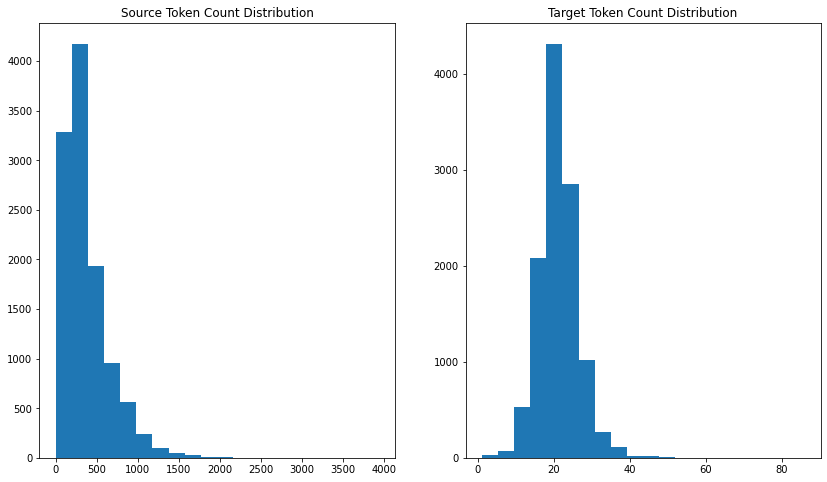

In [ ]:
import datasets
import random
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt

def show_random_elements(dataset, num_examples=5):
    ## YOUR CODE HERE ##
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))


def get_token_counts(dataset):
    ## YOUR CODE HERE ##
    src_counts = [len(x.split()) for x in dataset['document']]
    tgt_counts = [len(x.split()) for x in dataset['summary']]
    return src_counts, tgt_counts


def token_counts_summary(raw_dataset):
    ## YOUR CODE HERE ##
    for name,dataset in raw_dataset.items():
        src_counts, tgt_counts = get_token_counts(dataset)

        mean_cnt = np.mean(src_counts)
        std_cnt = np.std(src_counts)
        print(f'Source documents from dataset: {name:10}\tMean tokens: {mean_cnt:.2f}\tStd tokens: {std_cnt:.2f}')

        mean_cnt = np.mean(tgt_counts)
        std_cnt = np.std(tgt_counts)
        print(f'Target documents from dataset: {name:10}\tMean tokens: {std_cnt:.2f}\tStd tokens: {std_cnt:.2f}')


def plot_token_counts(dataset):
    ## YOUR CODE HERE ##
    src_counts, tgt_counts = get_token_counts(dataset)
    f, (ax0, ax1) = plt.subplots(1,2, figsize=(14,8))
    ax0.hist(src_counts, bins=20)
    ax1.hist(tgt_counts, bins=20)
    ax0.set_title("Source Token Count Distribution")
    ax1.set_title("Target Token Count Distribution")


# show_random_elements(raw_datasets["val"])

plot_token_counts(raw_datasets["validation"])

### Loading the metric

To evaluate our model's performance, we will use the ROUGE summarization metric. This is provided natively within the dataset library and can be loaded similarly to how we loaded the dataset above. **Note** this is a big advantage in practise as i) metrics can be fiddly to implement manually and ii) difficult to align completely across implmentations as decisions like lemmatization, tokenization and punctation-handling can create large discrepancies in scores.

You can call its `compute` method with your predictions and labels, which need to be list of decoded strings:

In [4]:
from datasets import load_metric
metric = load_metric("rouge")

# help(metric)      # << Uncomment to see more about the ROUGE eval metric

# Try it out below
# fake_preds = ## YOUR CODE HERE
# fake_labels = ## YOUR CODE HERE
## COMPUTE METRIC HERE ## 

fake_preds = ["i love nlp", "nlp is great"]
fake_labels = ["i love nlp", "nlp is fun"]
metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666), mid=Score(precision=0.8333333333333333, recall=0.8333333333333333, fmeasure=0.8333333333333333), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=0.5, recall=0.5, fmeasure=0.5), mid=Score(precision=0.75, recall=0.75, fmeasure=0.75), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666), mid=Score(precision=0.8333333333333333, recall=0.8333333333333333, fmeasure=0.8333333333333333), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=0.6666666666666666, recall=0.6666666666666666, fmeasure=0.6666666666666666), mid=Score(precision=0.8333333333333333, recall=0.8333333333333333, fmeasure=0.8333333333333333), high=Score(precision=1.0, recall=1.0, fmea

## Preprocessing the data

We will proprocess the data using the Huggingface `Tokenizer`. This tokenizes and indexes the inputs and put it in a format the model expects. It also generate the other inputs that the model requires.

-------------- Question ---------------------

1. Each Huggingface model has a paired tokenizer. Why is it important to use the appropriate tokenizer?

Answer: 
Otherwise the tokenizer vocabulary may not be aligned with the model's embedding matrics. This could result in i) incorrect token embeddings (as token indices are incorrect), ii) index errors (if the vocbulary shrinks) iii) incorrect sub-word tokenization (e.g. if the model was trained on sentencepiece but the tokenizer uses byte-pair-encoding)

In [5]:
from transformers import AutoTokenizer

model_checkpoint = "t5-small"       # Can find more options at https://huggingface.co/models?sort=downloads&search=t5    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

### Using the tokenizer

Try out the tokenizer in the cell below.

---------------- Question ---------------

1. The tokenizer output has different fields for different tokenizers. 

i) Confirm this by writing code below to instantiate a BERT tokenizer and comparing the outputs across the two tokenizers of when tokenizing a string. You may find [this page](https://huggingface.co/models) helpful.

ii) Why does the BERT tokenizer have an additional field to the T5 tokenizer?

Answer: most models were trained to recognize sequences defined using special tokens, e.g. [CLS] seq1 [SEP] seq2 [SEP] is a common encoding pattern for tasks involving two sequences. BERT was trained using an additional `token_type_ids` field to which is a binary mask flagging to explicitly differentiate between the two sequences. BERT will likely perform poorly evaluated without the type ids. See [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested to find out more about tokenization.


In [6]:
# Test the tokenizer below
print(tokenizer("We love NLP!"))
# print(tokenizer(## YOUR CODE HERE))

## CODE FOR 1.i) HERE ##
tokenizer_ = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_('We love NLP')

{'input_ids': [101, 333, 445, 6892, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1]}


{'input_ids': [101, 2057, 2293, 17953, 2361, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

### Additional tokenizer functionalities:

- The tokenizer can be fed a list of strings
- When tokenizing the target documents, using `tokenizer.as_target_tokenizer()` to ensure the target receives the appropriate special tokens (although here the source and target are tokenized identically)
- We can convert back from ids to tokens by using `tokenizer.convert_ids_to_tokens()`

--------------- Question --------------

1. The output of `tokenizer.convert_ids_to_tokens()` is different from the inital string. Why is this?

Answer: because of subword tokenization. Subwords are identified by sub-words not having an underscore.

In [7]:
print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

print(tokenizer.convert_ids_to_tokens(tokenizer("We love NLP!")['input_ids']))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}
{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}
['▁We', '▁love', '▁N', 'LP', '!', '</s>']


T5 was trained within a multitask framework such that it can perform multiple tasks out-of-the-box. We prefix the inputs with "summarize: " to prompt the model to deliver the correct outputs.

We can then write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model. The padding will be dealt with later on (in a data collator) so we pad examples to the longest length in the batch and not the whole dataset.

Complete the `preprocess_function` below to tokenize the text (**hint**: don't forget prefix or the context manager ;) )

In [8]:
prefix = "summarize: " if model_checkpoint.startswith("t5-") else ""

max_input_length = 1024
max_target_length = 128

def preprocess_function(examples):
    ## YOUR CODE HERE ##
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [9]:
# Test it using the below call
preprocess_function(raw_datasets['train'][:2])

{'input_ids': [[21603, 10, 37, 423, 583, 13, 1783, 16, 20126, 16496, 6, 80, 13, 8, 844, 6025, 4161, 6, 19, 341, 271, 14841, 5, 7057, 161, 19, 4912, 16, 1626, 5981, 11, 186, 7540, 16, 1276, 15, 2296, 7, 5718, 2367, 14621, 4161, 57, 4125, 387, 5, 15059, 7, 30, 8, 4653, 4939, 711, 747, 522, 17879, 788, 12, 1783, 44, 8, 15763, 6029, 1813, 9, 7472, 5, 1404, 1623, 11, 5699, 277, 130, 4161, 57, 18368, 16, 20126, 16496, 227, 8, 2473, 5895, 15, 147, 89, 22411, 139, 8, 1511, 5, 1485, 3271, 3, 21926, 9, 472, 19623, 5251, 8, 616, 12, 15614, 8, 1783, 5, 37, 13818, 10564, 15, 26, 3, 9, 3, 19513, 1481, 6, 18368, 186, 1328, 2605, 30, 7488, 1887, 3, 18, 8, 711, 2309, 9517, 89, 355, 5, 3966, 1954, 9233, 15, 6, 113, 293, 7, 8, 16548, 13363, 106, 14022, 84, 47, 14621, 4161, 6, 243, 255, 228, 59, 7828, 8, 1249, 18, 545, 11298, 1773, 728, 8, 8347, 1560, 5, 611, 6, 255, 243, 72, 1709, 1528, 161, 228, 43, 118, 4006, 91, 12, 766, 8, 3, 19513, 1481, 410, 59, 5124, 5, 96, 196, 17, 19, 1256, 68, 27, 103, 317, 132

This function can be applied to all our datasets using the `map` method of our `dataset` object. The results are automatically cached to avoid spending time on this step the next time you run your notebook. 

In [10]:
tokenized_datasets = raw_datasets.map(
    preprocess_function, 
    batched=True            # This employs multithreading to speed up tokenization
)

Loading cached processed dataset at /vol/bitbucket/aeg19/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934/cache-5ebb2d6a3db1bb19.arrow
Loading cached processed dataset at /vol/bitbucket/aeg19/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934/cache-933a7931c8603918.arrow
Loading cached processed dataset at /vol/bitbucket/aeg19/.cache/huggingface/datasets/xsum/default/1.2.0/32c23220eadddb1149b16ed2e9430a05293768cfffbdfd151058697d4c11f934/cache-6ce473e7288e00a1.arrow


## Using T5 out-of-the-box

In the lecture slides you were shown the below image:

![T5 img](figs/t5.png)

Here, we will experiment with some of T5's capabilities without pre-training. First, we will download the model using `AutoModelForSeq2SeqLM` class using the `from_pretrained` method (this caches the model for us).

To illustrate the impact of the prompt, we will try T5 using two different prompts using the same string. Note that we are using the small version without fine-tuning so the results may not be great.

In [11]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model.cuda()

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

### Your task
Complete the `tok_and_gen` function below. This requires the following steps:
- Tokenize the inputs
- Generate output ids (hint: using model.generate. Google this for more details)
- Convert the ids to string
- Print the string

In [12]:
input_str = 'Artificial general intelligence (AGI) is the hypothetical ability of an intelligent agent to understand or learn any intellectual task that a human being can.[1] It is a primary goal of some artificial intelligence research and a common topic in science fiction and futures studies.'

prefixes = ["translate English to German: ", "summarize: "]     # What happens if we make up a prompt? Why?

def tok_and_gen(model, tokenizer, input, prefix=''):
    ## YOUR CODE HERE ##
    inputs = tokenizer(prefix + input, return_tensors="pt", padding=True)

    output_sequences = model.generate(
        input_ids=inputs["input_ids"].cuda(),
        attention_mask=inputs["attention_mask"].cuda(),
    )

    print(f'Using prefix {task_prefix}: ', tokenizer.batch_decode(output_sequences, skip_special_tokens=True))


for task_prefix in prefixes:
    tok_and_gen(model, tokenizer, task_prefix, input_str)    


Using prefix translate English to German: :  ['Die künstliche allgemeine Intelligenz (AGI) ist die']
Using prefix summarize: :  ['artificial intelligence is the hypothetical ability of an intelligent agent to understand or learn any intellectual task that ']


## Fine-tuning the model

Now that our data is ready and we have played around with our model, we can fine-tune it. 

HuggingFace provides an API for training a seq2seq model: the `Seq2SeqTrainer`. To instantiate this, we will need to define three more things. The most important is the [`Seq2SeqTrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Seq2SeqTrainingArguments), which is a class that contains all the attributes to customize the training. It requires a folder name for saving checkpoints of the model, and all other arguments are optional:

In [13]:
batch_size = 4
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",     # Ouptut folder
    # Eval strategy
    evaluation_strategy="steps",
    eval_steps=100,
    # Could alternatively be the following to eval every epoch:
    # evaluation_strategy="epoch",

    # LR. Should be small (<1e-4)
    learning_rate=2e-5,

    # Batch size during training and eval
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,

    # Limits the number of models saved during training. Important to prevent memory clogging up!
    save_total_limit=3,

    # Properly generate summaries during eval
    predict_with_generate=True,
    
    # Mixed precision training (speeds up training - see Nvidia-apex for more details)
    fp16=True,

    weight_decay=0.01,
    num_train_epochs=1,
)

Then, we need a special kind of data collator, which will not only pad the inputs to the maximum length in the batch, but also the labels:

In [14]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

The last thing to define for our `Seq2SeqTrainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, and we have to do a bit of pre-processing to decode the predictions into texts:

In [15]:
import nltk
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`. This is the general Huggingface API adapted for training seq2seq models.

## Your task 
- Instantiate the trainer class and begin finetuning on the XSum dataset. You may find [this page](https://huggingface.co/docs/transformers/main_classes/trainer) helpful.

**Note:** training will likely take a while so you may want to end training once you are satisfied it is working correctly in order to progress to the next section.

In [16]:
## YOUR CODE HERE ##
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
trainer.train()

Using amp half precision backend


## Complexity Analysis

Here we will analyze the computational complexity of the Transformer. One of the main drawbacks of this architecture is that the time and memory complexity scales poorly with respect to input length. This is particularly problematic for summarization as long document summarization can become prohibitively expensive.

---------------- Questions/tasks ----------------

1. Which component of the Transformer does the poor complexity problems mentioned above referred to? Explain why this is the case.
2. We will profile the time complexity of T5 for different input sequence lengths. Complete the function below which will plot the time of T5's forward pass. You can use the inbuilt pytorch profiler or a simpler method (e.g. `time.time`) as you prefer.
- We will first do this up to 512 tokens on a log base 2 scale (i.e. 1, 2, 4, 8, ... 512)
- Do this for the encoder (holding decoder input length fixed) and the decoder (holding encoder input length fixed)


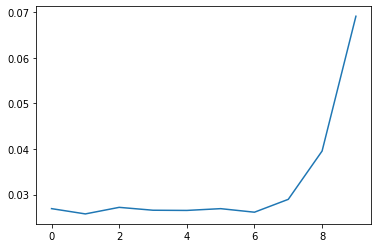

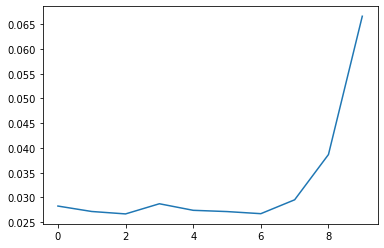

In [20]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained('t5-small')
model.cuda()
import torch


from time import time
import matplotlib.pyplot as plt

def profile_seq2seq(model, max_len, batch_size=1):
    # Create dummy input tensors
    base_encoder_input = torch.tensor([[10]]).cuda()
    base_decoder_input = torch.tensor([[10]]).cuda()
    # Make a larger batch to make trends more evident
    base_encoder_input = base_encoder_input.repeat(batch_size,1)
    base_decoder_input = base_decoder_input.repeat(batch_size,1)
    
    ## YOUR CODE HERE ##
    # Benchmark encoder holding decoder fixed
    run_time_profile(model, max_len, base_encoder_input, base_decoder_input, 'encoder', True)

    # Benchmark decoder holding encoder fixed
    run_time_profile(model, max_len, base_encoder_input, base_decoder_input, 'decoder', True)


def run_time_profile(model, max_len, base_encoder_input, base_decoder_input, vary, do_plot=False, n_trials=2):
    times = []
    for i in range(torch.log2(torch.tensor(max_len)).int()+1):
        len = 2 ** i
        
        encoder_input = base_encoder_input
        decoder_input = base_decoder_input
        if vary == 'encoder':
           encoder_input = base_encoder_input.repeat(1,len)
        elif vary == 'decoder':
           decoder_input = base_decoder_input.repeat(1,len) 

        # print(encoder_input.shape, decoder_input.shape)
        ts = time()
        for i in range(n_trials):
            model(input_ids=encoder_input, decoder_input_ids=decoder_input)
        te = time()
        times.append(te - ts)

    if do_plot:
        plt.plot(times)
        plt.show()

    return times


profile_seq2seq(model, max_len, 8)


## Modifying T5 to use longer sequences

The above plots may or may not show an upward trajectory. Now try again with a larger batch size (e.g. 8). Now they should show an upward slope as the forward pass becomes more expensive relative to other overheads.

The upward trajectory shows that the forward pass becomes more expensive as the sequence gets longer. However, we are still operating with short sequences. This trend will become clear for batch_size=1 if we are able to use longer sequences, but we are unable to exceed 512 tokens as this would exceed T5's embedding size.

Below we will modify T5 to allow it to ingest longer sequences. This involves repeating the embedding matrix horizontally to the desired maximum length. Currently T5's embedding matrix is 512 tokens wide (including one reserved for the special token). Here we will extend the encoder's embedding matrix 8 times to 4089 tokens (511*8 + 1 for the special token). **Note** this technique is sometimes used in practise for long sequence tasks, but the model should be fine-tuned as the positial encodings in the repeated sections will not be optimal.

### Your task

Complete the `extend_embeddings` function below.

In [24]:
def extend_embeddings(model, widen_factor):
    embed_size = model.encoder.embed_tokens
    # allocate a larger position embedding matrix for the encoder
    new_encoder_pos_embed = model.model.encoder.embed_positions.weight.new_empty(max_pos, embed_size)
    # copy position embeddings over and over to initialize the new position embeddings
    k = 2
    step = current_max_pos - 2
    while k < max_pos - 1:
        new_encoder_pos_embed[k:(k + step)] = model.model.encoder.embed_positions.weight[2:]
        k += step
    model.model.encoder.embed_positions.weight.data = new_encoder_pos_embed

{'input_ids': tensor([[  27,  114,    1],
        [  71, 2701,    1]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]])}